## Because we have achieved better results with a simple logistic regression on hate speech detection I wanted to see what was the result with Sentiment140 dataset (cleaned_data.csv)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
import nltk
import re
import string
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Import Sentiment140 CSV
We use cleaned_data.csv because it also contains the uncleaned text column  
(We'll "clean the unclean column" to be sure that the cleaning part doesn't influence results)

In [2]:
data = pd.read_csv(
    "cleaned_data.csv",
    encoding='latin-1')
data['clean_text'] = data.clean_text.astype(str)
data['polarity'] = pd.to_numeric(data['polarity'], downcast='integer')

print(data.head())

   polarity                                               text  \
0         0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1         0  is upset that he can't update his Facebook by ...   
2         0  @Kenichan I dived many times for the ball. Man...   
3         0    my whole body feels itchy and like its on fire    
4         0  @nationwideclass no, it's not behaving at all....   

                                          clean_text  
0   awww bummer you shoulda got david carr third day  
1  upset updat facebook text might cri result sch...  
2      dive mani time ball manag save the rest bound  
3                    whole bodi feel itchi like fire  
4                                      behav mad see  


# Define the function to clean the dataframe

In [3]:
def clean_text(text):
    # remove users tags and url
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    # remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    # tokenize
    text = re.split('\W+', text)
    # remove stop-word
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    
    # After testing I've discovered that stemming and lammitization do not improve results
    # Stemming
    #ps = nltk.PorterStemmer()
    #text = [ps.stem(word) for word in text]
    # Lammitization
    #wn = nltk.WordNetLemmatizer()
    #text = [wn.lemmatize(word) for word in text]
    
    # remove empty words
    text = [word for word in text if word != '']
    # rejoin for easier one-hot extraction
    text = ' '.join(text)
    # remove one letters words
    new_text = []
    for w in text.split(" "):
        if len(w) > 1:
            new_text.append(w)
    text = " "
    
    return text.join(new_text)

# Clean the text

In [4]:
data['clean_text'] = data['text'].apply(lambda x: clean_text(x))
data['lower_case_text'] = data.clean_text.map(lambda x: x.lower() if isinstance(x,str) else x)


# Show difference of words between tweets polarity

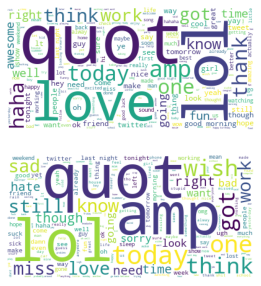

In [18]:
hate_data = data[data['polarity'] == 1]
non_hate_data = data[data['polarity'] == 0]

cloud_stopwords = set(STOPWORDS)

# fig, ax = plt.subplots(1,2, figsize=(20,5))
fig = plt.figure(figsize=(20,5))

print("hate data vs non-hate-data")
hate_word_cloud = WordCloud(background_color='white', stopwords=cloud_stopwords).generate(hate_data['lower_case_text'].str.cat(sep=', '))
ax = fig.add_subplot(2,1,1)
plt.imshow(hate_word_cloud)
ax.axis('off')

non_hate_word_cloud = WordCloud(background_color='white', stopwords=cloud_stopwords).generate(non_hate_data['lower_case_text'].str.cat(sep=', '))
ax = fig.add_subplot(2,1,2)
plt.imshow(non_hate_word_cloud)
ax.axis('off')


# We delete both df because we won't use them after
del hate_data, non_hate_data

# Split test/train data

In [6]:
df_train, df_test = train_test_split(data, test_size=0.25, random_state=1, shuffle=True)

# Convert text to vector with TfIdf

In [7]:
tokenizer = TweetTokenizer().tokenize

vect_tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', ngram_range=(1,3), max_df=0.3)
vect_tfidf.fit(df_train['lower_case_text'].values)

X_train = vect_tfidf.transform(df_train['lower_case_text'].values)
X_test = vect_tfidf.transform(df_test['lower_case_text'].values)

print(f'''X_train shape = {X_train.shape}''')

y_train = df_train.polarity.values.copy()
y_test = df_test.polarity.values.copy()

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


X_train shape = (1200000, 7948709)


# Oversample train data with SMOTE
Results where not better with it so the main line is commented

In [8]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# transform the dataset
oversample = SMOTE()
#X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print(counter)

Counter({1: 600249, 0: 599751})


# Build logistic regression model

In [9]:
logreg = LogisticRegression(n_jobs=-1,C= 10, class_weight= 'balanced', penalty= 'l2', random_state= 1)

logreg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', n_jobs=-1, random_state=1)

# Make prediction

In [10]:
y_pred = logreg.predict(X_test)

# Evaluate model performance
Here we can use accuracy or f1_score because this is a balanced dataset so accuracy = f1_score

[[155345  44904]
 [ 43162 156589]]


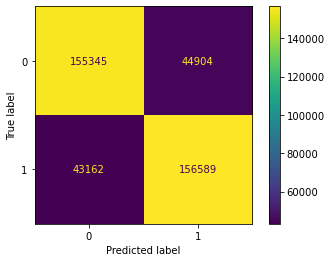

In [11]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

plot_confusion_matrix(logreg, X_test, y_test)
plt.show()

In [12]:
print("f1_score of the model : ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1_score of the model :  0.780517590294185
              precision    recall  f1-score   support

           0       0.78      0.78      0.78    200249
           1       0.78      0.78      0.78    199751

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.78      0.78      0.78    400000

